In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data.dataset import Dataset
from logger import Logger
from model_instance import Model_Instance


In [2]:
train_transform = transforms.Compose(
    [transforms.RandomRotation(20),
     transforms.RandomHorizontalFlip(0.3),
     transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
                            contrast = 0.1, 
                            saturation = 0.1), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def get_dataloader(batch_size):
    

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=4)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=test_transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=4)
    return trainloader,testloader
trainloader,testloader = get_dataloader(32)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


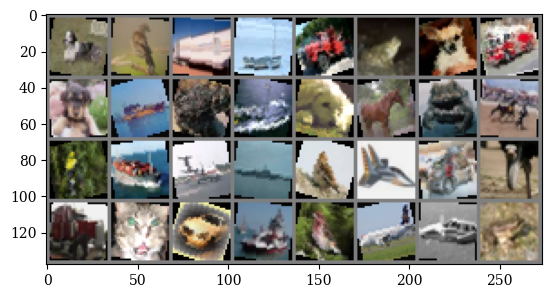

dog   bird  truck ship  truck frog  dog   truck dog   ship  frog  ship  dog   horse frog  horse bird  ship  plane ship  bird  plane car   bird  truck cat   car   ship  bird  plane plane frog 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))

In [4]:
@torch.no_grad()
def evaluation(model,dataloader,step):
    model.eval()
  # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    classes_acc={classname: 0 for classname in classes}
    correct=0
    total=0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # _,outputs,_ = model(images.to(device))
            outputs = model(images.to(device))
            outputs = outputs.cpu()
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct+=1
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
                total+=1

    print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')
    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        classes_acc[classname]=[accuracy]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    record_df = pd.DataFrame.from_dict(classes_acc)
    record_df['step']=step
    model.train()
    return record_df

In [5]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
#from resnet import get_resnet34
logger = Logger('test')
config=logger.config
config['train_step']=300
config['valid_step']=100
config['lr']=1e-3
config['batch_size']=512
config['device']= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(config['device'])

trainloader,testloader = get_dataloader(config.batch_size)


model = torchvision.models.resnet101()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(),lr=config['lr'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['train_step'])
model_instance = Model_Instance(model=model,
                                optimizer=optimizer,
                                loss_function=criterion,
                                evaluation_metrics=['acc','f1score'],
                                scheduler=scheduler,#iter
                                scheduler_iter=True,
                                device=config.device)

a=model_instance.run_step_dataloader(trainloader,
                                     run_step=config.train_step,
                                     valid_step=config.valid_step,
                                     logger=logger['Tra'],
                                     evaluation_function=lambda: model_instance.run_dataloader(testloader,logger=logger['Valid'],update=False))



cuda:0
Files already downloaded and verified
Files already downloaded and verified


Tra   5%|█                   | 5/98 [00:01<00:18,  5.08it/s]

---------
【Valid】:
acc	:0.382
f1score	:0.358
loss	:1.719
step	:20
---------
---------
【Tra】:
acc	:0.279
f1score	:0.02
loss	:2.1
step	:100
---------


Tra   7%|█▍                  | 7/98 [00:01<00:15,  5.99it/s]

---------
【Valid】:
acc	:0.446
f1score	:0.438
loss	:1.521
step	:20
---------
---------
【Tra】:
acc	:0.343
f1score	:0.025
loss	:1.874
step	:200
---------


Tra   5%|█                   | 5/98 [00:01<00:29,  3.10it/s]

---------
【Valid】:
acc	:0.466
f1score	:0.46
loss	:1.473
step	:20
---------
---------
【Tra】:
acc	:0.38
f1score	:0.027
loss	:1.751
step	:300
---------


,experiment_name,tag,acc,f1score,loss,step
0,test,Tra,0.277360,0.017841,2.079432,100.0
1,test,Valid,0.360500,0.343268,1.765987,20.0
2,test,Tra,0.344769,0.022224,1.848651,200.0
3,test,Valid,0.440400,0.435679,1.536107,20.0
4,test,Tra,0.383819,0.024796,1.727029,300.0
5,test,Valid,0.477500,0.472606,1.438280,20.0
6,test,Tra,0.270794,0.018748,2.098628,100.0
7,test,Valid,0.384900,0.372743,1.703692,20.0
8,test,Tra,0.335440,0.023319,1.877181,200.0
9,test,Valid,0.448100,0.444142,1.528243,20.0


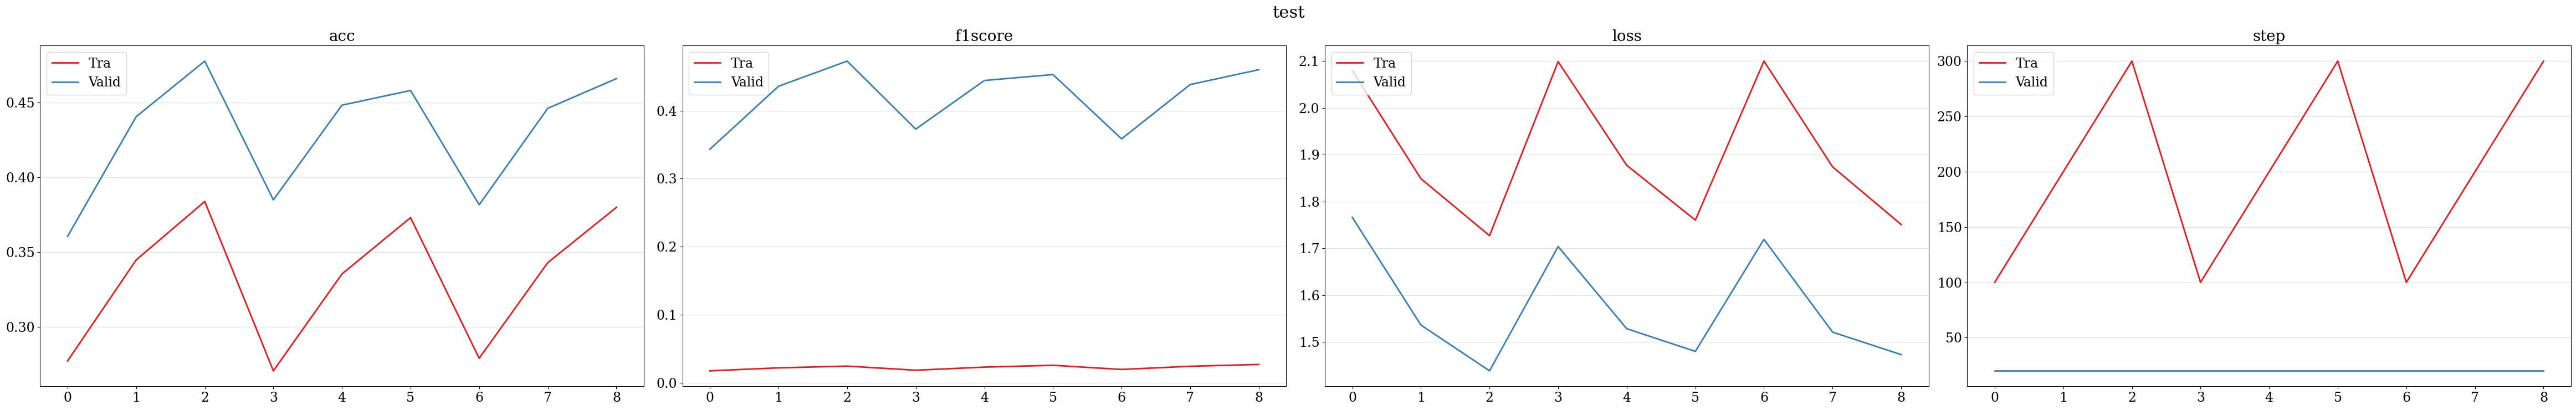

Export Success! 
 File Path:logger_file/test/logger_history


In [8]:
display(logger.history['records'])
logger.plot_experiments()
logger.export_logger()

In [7]:
config

{'train_step': 300,
 'valid_step': 100,
 'lr': 0.001,
 'batch_size': 512,
 'device': 'cuda:0'}